# 3. Fitting models to data

In this workbook we will import data and find the cosmological model that best fits that data. 

### 3.1 First set up the packages and functions
We need to know the distance modulus as a function of redshift.  Distance modulus is defined as 
\begin{equation} \mu(z) = 5 \log_{10}(D_L)\end{equation}
where
\begin{equation} D_L = R_0 S_k(\chi) (1+z) \end{equation}
and $S_k(\chi)=\sin(\chi), \chi,\; {\rm or}\; \sinh(\chi)$ for closed, flat, and open universes respectively, and
\begin{equation} R_0\chi = \frac{c}{H_0}\int_0^z \frac{dz}{E(z)}\end{equation}
with $E(z)=H(z)/H_0$.

Note that the absolute magnitude of the SNe is about -19.5, but it enters as an additive constant in the same way as $c/H_0$ and both have high uncertainty.  Therefore we *marginalise* over this offset and it doesn't matter what value of $H_0$ we use.

#### Important: In the code below, replace ez = 1.0 with the actual function for E(z).


In [1]:
# First let's set up our packages
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

# And set some constants
c = 299792.458 # km/s (speed of light)
H0kmsmpc = 70.  # Hubble constant in km/s/Mpc
H0s = H0kmsmpc * 3.2408e-20 # H0 in inverse seconds is H0 in km/s/Mpc * (3.2408e-20 Mpc/km)

# Write a function for the integrand, i.e. $1/E(z)$,
def ezinv(z,om=0.3,ol=0.7,w0=-1.0,wa=0.0,orr=0.0):
    ok = 1.-om-ol-orr
    ez = np.sqrt((om*(1+z)**3)+(ok*(1+z)**2)+ol)
    return 1./ez

# The curvature correction function
def Sk(xx, ok):
    if ok < 0.0:
        dk = np.sin(np.sqrt(-ok)*xx)/np.sqrt(-ok)
    elif ok > 0.0:
        dk = np.sinh(np.sqrt(ok)*xx)/np.sqrt(ok)
    else:
        dk = xx
    return dk

# The distance modulus
def dist_mod(zs,om=0.3,ol=0.7,w0=-1.0,wa=0.0,orr=0.0):
    """ Calculate the distance modulus, correcting for curvature"""
    ok = 1.0 - om - ol
    xx = np.array([integrate.quad(ezinv, 0, z, args=(om, ol, w0, wa, orr))[0] for z in zs])
    D = Sk(xx, ok)
    lum_dist = D * (1 + zs) 
    dist_mod = 5 * np.log10(lum_dist) # Distance modulus
    # Add an arbitrary constant that's approximately the log of c on Hubble constant minus absolute magnitude of -19.5
    dist_mod = dist_mod + np.log(c/H0kmsmpc)-(-19.5)  # You can actually skip this step and it won't make a difference to our fitting
    return dist_mod

### 3.2 Now read in the data
I have generated some mock supernova data at random redshifts between $0.02<z<1.0$.  I then choose a cosmological model and calculate the distance modulus for each redshift in that model.  Then I give some uncertainty to the data points and scatter them randomly about the correct model by an amount corresponding to their uncertainty. 

I've generated 5 different models, all in files called DataX.txt, where X is a number from 0-4. 

There are five possible variables that I have specified in the models.  These are
* Matter density: $\Omega_M$ suing 
* Dark Energy density: $\Omega_\Lambda$
* Radiation density: $\Omega_R$
* Equation of state of dark energy: $w_0$
* Change in the equation of state with scalefactor: $w_a$, where $w=w_0+w_a(1-a)$.

You can test your code on Data00.txt and Data0.txt.  Both were generated using a model with $(\Omega_M,\Omega_{\Lambda})=(0.3,0.7)$ and all other parameters set to their standard values, namely $\Omega_R=0.0$, $w_0=-1.0$, $w_a=0.0$.  In addition Data00.txt has perfect data with no scatter and small uncertainties, so you should be able to recover exactly the correct model. 

Data sets 1-2 are models in which $\Omega_R=0.0$, $w_0=-1.0$, $w_a=0.0$ and only $\Omega_M$ and $\Omega_{\Lambda}$ change.  

Data sets 3-4 could be anything! (Within the realms of the five parameters described above.)

Feel free to choose which data set you want to analyse for your project.


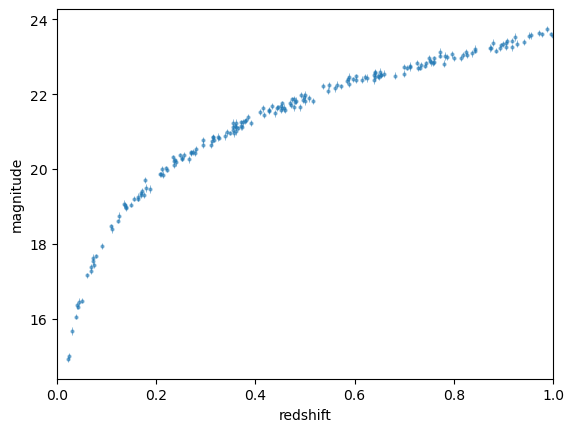

In [5]:
# Add a new function that reads in the data (data files should be in a directory called data)
def read_data(model_name):
    d = np.genfromtxt('data/'+model_name+'.txt',delimiter=',')
    zs = d[:,0]
    mu = d[:,1]
    muerr=d[:,2]
    # Sort the arrays based on zs
    sort_idx = np.argsort(zs)
    zs = zs[sort_idx]
    mu = mu[sort_idx]
    muerr = muerr[sort_idx]
    return zs, mu, muerr

zs, mu, muerr = read_data('data2')

# Plot it to see what it looks like, this is called a Hubble diagram
plt.errorbar(zs,mu,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
plt.xlim(0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude')
plt.show()

In [23]:
print(len(mu))

740


### 3.3 Calculate the theory corresponding to that data for a range of cosmological models
Then overplot them on the Hubble diagram.  Here we're just testing some specific interesting examples.
It's always important to visualise your data and check that the models and data are doing what you think they are!

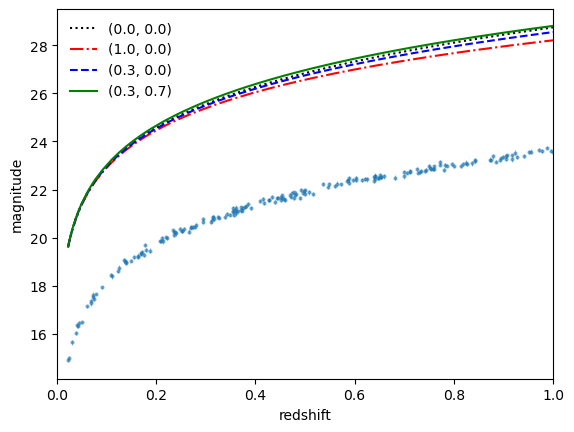

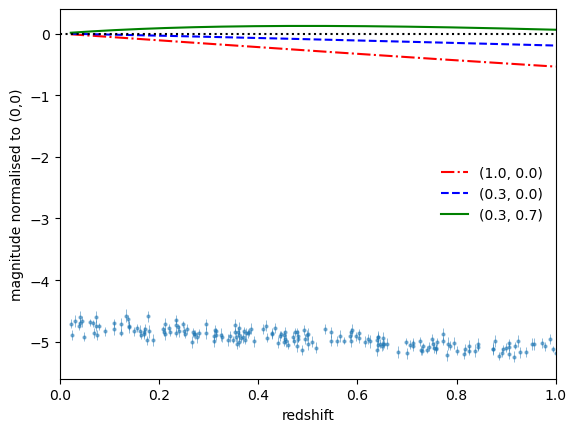

In [6]:
mu_om00_ox00 = dist_mod(zs,om=0.0,ol=0.0)  # We're going to use this empty model as a benchmark to compare the others to
mu_om10_ox00 = dist_mod(zs,om=1.0,ol=0.0)
mu_om03_ox00 = dist_mod(zs,om=0.3,ol=0.0)
mu_om03_ox07 = dist_mod(zs,om=0.3,ol=0.7)

# Plot it to see what it looks like, this is called a Hubble diagram
plt.errorbar(zs,mu,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
plt.plot(zs,mu_om00_ox00,':',color='black',label='(0.0, 0.0)')
plt.plot(zs,mu_om10_ox00,'-.',color='red',label='(1.0, 0.0)')
plt.plot(zs,mu_om03_ox00,'--',color='blue',label='(0.3, 0.0)')
plt.plot(zs,mu_om03_ox07,'-',color='green',label='(0.3, 0.7)')
plt.xlim(0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude')
plt.legend(frameon=False)
plt.show()

# Now plot a Hubble diagram relative to the empty model (i.e. subtract the empty model from all the data and models)
plt.errorbar(zs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
plt.plot(zs,mu_om10_ox00-mu_om00_ox00,'-.',color='red',label='(1.0, 0.0)')
plt.plot(zs,mu_om03_ox00-mu_om00_ox00,'--',color='blue',label='(0.3, 0.0)')
plt.plot(zs,mu_om03_ox07-mu_om00_ox00,'-',color='green',label='(0.3, 0.7)')
plt.axhline(y=0.0,ls=':',color='black')
plt.xlim(0.0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude normalised to (0,0)')
plt.legend(frameon=False)
plt.show()

### 3.4 Normalise the theory
You can see that there is a vertical offset between the different theory curves.  
We marginalise over this vertical offset, because we do not have enough information to constrain the vertical offset independently.
In other words we use the data to determine what the vertical offset should be, but we do not care about what the answer is!
(We are interested in the other parameters in the fit, but not that one.  The other parameters determine the *shape* of the curve.)

The easiest way to normalise the curves is to take a weighted average of the difference between the data points and the theory in each case.

4.665325678425232 4.835205296098892 5.019743809454276


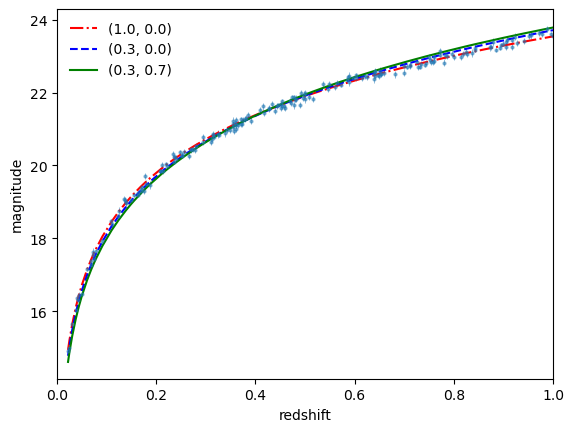

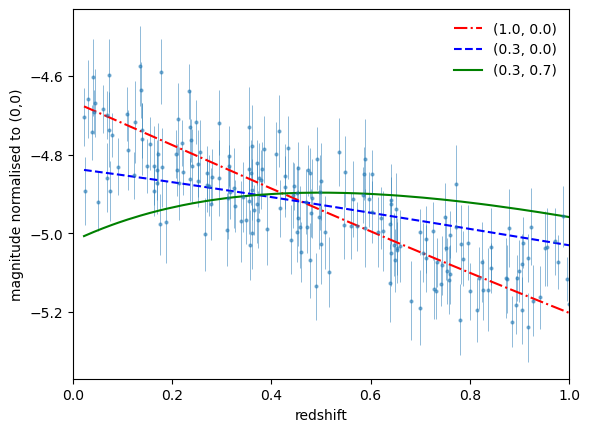

In [7]:
# Calculate mscript for each of these, which is the thing that determines the vertical normalisation 
mscr_om10_ox00 = np.sum((mu_om10_ox00-mu)/muerr**2)/np.sum(1./muerr**2)
mscr_om03_ox00 = np.sum((mu_om03_ox00-mu)/muerr**2)/np.sum(1./muerr**2)
mscr_om03_ox07 = np.sum((mu_om03_ox07-mu)/muerr**2)/np.sum(1./muerr**2)

print(mscr_om10_ox00,mscr_om03_ox00,mscr_om03_ox07)

mu_om10_ox00=mu_om10_ox00-mscr_om10_ox00
mu_om03_ox00=mu_om03_ox00-mscr_om03_ox00
mu_om03_ox07=mu_om03_ox07-mscr_om03_ox07

# Repeat the plot and see how it changes
# Plot it to see what it looks like, this is called a Hubble diagram
plt.errorbar(zs,mu,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
plt.plot(zs,mu_om10_ox00,'-.',color='red',label='(1.0, 0.0)')
plt.plot(zs,mu_om03_ox00,'--',color='blue',label='(0.3, 0.0)')
plt.plot(zs,mu_om03_ox07,'-',color='green',label='(0.3, 0.7)')
plt.xlim(0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude')
plt.legend(frameon=False)
plt.show()

# Now plot a Hubble diagram relative to the empty model (i.e. subtract the empty model from all the data and models)
plt.errorbar(zs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
plt.plot(zs,mu_om10_ox00-mu_om00_ox00,'-.',color='red',label='(1.0, 0.0)')
plt.plot(zs,mu_om03_ox00-mu_om00_ox00,'--',color='blue',label='(0.3, 0.0)')
plt.plot(zs,mu_om03_ox07-mu_om00_ox00,'-',color='green',label='(0.3, 0.7)')
#plt.axhline(y=0.0,ls=':',color='black')
plt.xlim(0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude normalised to (0,0)')
plt.legend(frameon=False)
plt.show()

## 3.5 Perform a fit to many models 
To find the best model that best matches the data use a $\chi^2$ test.


No priors

In [8]:
# Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
n = 21                      # Increase this for a finer grid
oms = np.linspace(0.0, 0.5, n)   # Array of matter densities
ols = np.linspace(0.0, 1.0, n)   # Array of cosmological constant values
chi2 = np.ones((n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values

# Calculate Chi2 for each model
for i, om in enumerate(oms):                                          # loop through matter densities
       for j, ol in enumerate(ols):                                  # loop through cosmological constant densities
            mu_model = dist_mod(zs, om=om, ol=ol)                     # calculate the distance modulus vs redshift for that model 
            mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
            mu_model_norm = mu_model-mscr                             # Apply the vertical offset
            chi2[i,j] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix 
            
# Convert that to a likelihood and calculate the reduced chi2
likelihood = np.exp(-0.5 * (chi2-np.amin(chi2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
chi2_reduced = chi2 / (len(mu)-2)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# Calculate the best fit values (where chi2 is minimum)
indbest = np.argmin(chi2)                 # Gives index of best fit but where the indices are just a single number
ibest   = np.unravel_index(indbest,[n,n]) # Converts the best fit index to the 2d version (i,j)
print( 'Best fit values are (om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]] ) )
print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest[0],ibest[1]] )

Best fit values are (om,ol)=(0.500,0.000)
Reduced chi^2 for the best fit is 1.30


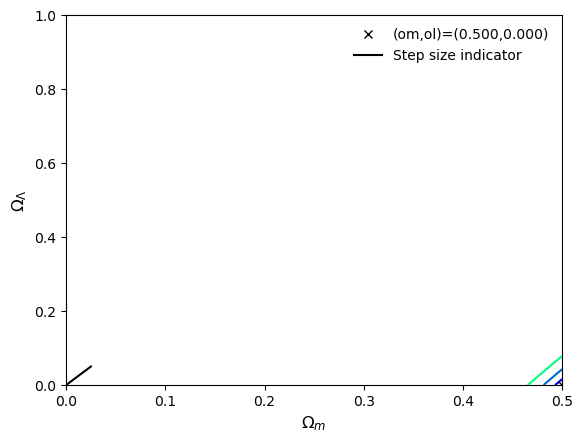

In [9]:
# Plot contours of 1, 2, and 3 sigma
plt.contour(oms,ols,np.transpose(chi2-np.amin(chi2)),cmap="winter",**{'levels':[2.30,6.18,11.83]})
plt.plot(oms[ibest[0]], ols[ibest[1]],'x',color='black',label='(om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]]) )
plt.xlabel("$\Omega_m$", fontsize=12)
plt.ylabel("$\Omega_\Lambda$", fontsize=12)
plt.plot([oms[0],oms[1]], [ols[0],ols[1]],'-',color='black',label='Step size indicator' ) # Delete this line after making step size smaller!
plt.legend(frameon=False)
#plt.savefig('plots/contours.png', bbox_inches="tight", transparent=True)
plt.show()
plt.close()

INCLUDE PRIOR of OM=0.27 +/- 0.03

In [6]:
# Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
p_om = 0.3                 #  Prior om
p_om_err = 0.05              # Prior om uncertainty
n = 20                      # Increase this for a finer grid
oms = np.linspace(0.0, 0.5, n)   # Array of matter densities
ols = np.linspace(0, 1.0, n)   # Array of cosmological constant values
chi2 = np.ones((n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values
pri2 = np.ones((n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values
tot2 = np.ones((n, n)) * np.inf 

# Calculate Chi2 for each model
for i, om in enumerate(oms):                                          # loop through matter densities
        for j, ol in enumerate(ols):                                  # loop through cosmological constant densities
            mu_model = dist_mod(zs, om=om, ol=ol)                     # calculate the distance modulus vs redshift for that model 
            mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
            mu_model_norm = mu_model-mscr                             # Apply the vertical offset
            chi2[i,j] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix
            pri2[i,j] = ((om - p_om) ** 2 / p_om_err**2)  # chi prior
            tot2[i,j] = pri2[i,j] + chi2[i,j]                                   # Total chi^2
            
# Convert that to a likelihood and calculate the reduced chi2
likelihood_t = np.exp(-0.5 * (tot2-np.amin(tot2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
tot2_reduced = tot2 / (len(mu)-2)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# Calculate the best fit values (where chi2 is minimum)
indbest = np.argmin(tot2)                 # Gives index of best fit but where the indices are just a single number
ibest   = np.unravel_index(indbest,[n,n]) # Converts the best fit index to the 2d version (i,j)
print( 'Best fit values are (om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]] ) )
print( 'Reduced tot^2 for the best fit is %0.2f'%tot2_reduced[ibest[0],ibest[1]] )

Best fit values are (om,ol)=(0.263,0.632)
Reduced tot^2 for the best fit is 1.12


INCLUDE PRIOR of OM=0.27 +/- 0.05
AND
INCLUDE PRIOR of OM+OL=1.00 +/- 0.02

In [22]:
# Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
p_om = 0.27                 #  Prior om
p_om_err = 0.03              # Prior om uncertainty
p_omol = 1.00                 #  Prior om+0l
p_omol_err = 0.02            # Prior om uncertainty
n = 30                      # Increase this for a finer grid
oms = np.linspace(0.0, 0.5, n)   # Array of matter densities
ols = np.linspace(0, 1.0, n)   # Array of cosmological constant values
chi2 = np.ones((n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values
prif2 = np.ones((n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values
tot2 = np.ones((n, n)) * np.inf 
prim2 = np.ones((n, n)) * np.inf 

# Calculate Chi2 for each model
for i, om in enumerate(oms):                                          # loop through matter densities
        for j, ol in enumerate(ols):                                  # loop through cosmological constant densities
            mu_model = dist_mod(zs, om=om, ol=ol)                     # calculate the distance modulus vs redshift for that model 
            mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
            mu_model_norm = mu_model-mscr                             # Apply the vertical offset
            chi2[i,j] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix
            prif2[i,j] = (((om+ol) - p_omol) ** 2 / p_omol_err**2)  # chi prior
            prim2[i,j] = ((om - p_om) ** 2 / p_om_err**2)  # chi prior
            tot2[i,j] = prif2[i,j] + chi2[i,j] + prim2[i,j]                                  # Total chi^2
            
# Convert that to a likelihood and calculate the reduced chi2
likelihood_t = np.exp(-0.5 * (tot2-np.amin(tot2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
tot2_reduced = tot2 / (len(mu)-2)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# Calculate the best fit values (where chi2 is minimum)
indbest = np.argmin(tot2)                 # Gives index of best fit but where the indices are just a single number
ibest   = np.unravel_index(indbest,[n,n]) # Converts the best fit index to the 2d version (i,j)
print( 'Best fit values are (om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]] ) )
print( 'Reduced tot^2 for the best fit is %0.4f'%tot2_reduced[ibest[0],ibest[1]] )

Best fit values are (om,ol)=(0.293,0.690)
Reduced tot^2 for the best fit is 1.6831


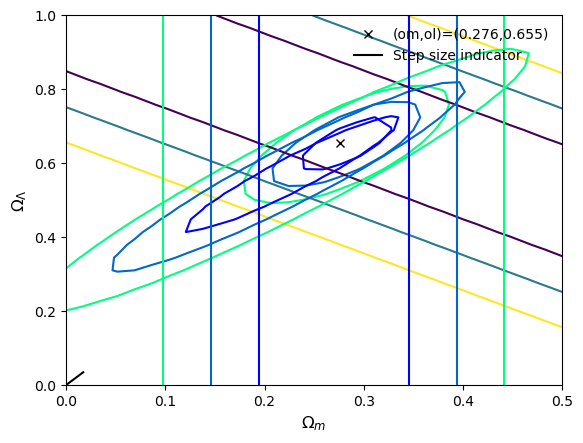

In [21]:
# Plot contours of 1, 2, and 3 sigma
#plt.contour(oms,ols,np.transpose(tot2-np.amin(tot2)),cmap="winter",**{'levels':[2.30,6.18,11.83]})
#plt.contour(oms,ols,np.transpose(prif2-np.amin(prif2)),cmap="winter",**{'levels':[2.30,6.18,11.83]})
plt.contour(oms,ols,np.transpose(prif2-np.amin(prif2)),**{'levels':[2.30,6.18,11.83]})
plt.contour(oms,ols,np.transpose(chi2-np.amin(chi2)),cmap="winter",**{'levels':[2.30,6.18,11.83]})
plt.contour(oms,ols,np.transpose(prim2-np.amin(prim2)),cmap="winter",**{'levels':[2.30,6.18,11.83]})
plt.plot(oms[ibest[0]], ols[ibest[1]],'x',color='black',label='(om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]]) )
plt.xlabel("$\Omega_m$", fontsize=12)
plt.ylabel("$\Omega_\Lambda$", fontsize=12)
plt.plot([oms[0],oms[1]], [ols[0],ols[1]],'-',color='black',label='Step size indicator' ) # Delete this line after making step size smaller!
plt.legend(frameon=False)
#plt.savefig('plots/contours.png', bbox_inches="tight", transparent=True)
plt.show()
plt.close()


w vs Omega_M

In [ ]:
# Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
n = 15                      # Increase this for a finer grid
oms = np.linspace(0.0, 0.5, n)   # Array of matter densities
ols = np.linspace(0.0, 1.0, n)   # Array of cosmological constant values
chi2 = np.ones((n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values

# Calculate Chi2 for each model
for i, om in enumerate(oms):                                          # loop through matter densities
       for j, ol in enumerate(ols):                                  # loop through cosmological constant densities
            mu_model = dist_mod(zs, om=om, ol=ol)                     # calculate the distance modulus vs redshift for that model 
            mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
            mu_model_norm = mu_model-mscr                             # Apply the vertical offset
            chi2[i,j] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix 
            
# Convert that to a likelihood and calculate the reduced chi2
likelihood = np.exp(-0.5 * (chi2-np.amin(chi2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
chi2_reduced = chi2 / (len(mu)-2)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# Calculate the best fit values (where chi2 is minimum)
indbest = np.argmin(chi2)                 # Gives index of best fit but where the indices are just a single number
ibest   = np.unravel_index(indbest,[n,n]) # Converts the best fit index to the 2d version (i,j)
print( 'Best fit values are (om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]] ) )
print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest[0],ibest[1]] )

In [ ]:
# Plot contours of 1, 2, and 3 sigma
plt.contour(oms,ols,np.transpose(chi2-np.amin(chi2)),cmap="winter",**{'levels':[2.30,6.18,11.83]})
plt.plot(oms[ibest[0]], ols[ibest[1]],'x',color='black',label='(om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]]) )
plt.xlabel("$\Omega_m$", fontsize=12)
plt.ylabel("$\Omega_\Lambda$", fontsize=12)
plt.plot([oms[0],oms[1]], [ols[0],ols[1]],'-',color='black',label='Step size indicator' ) # Delete this line after making step size smaller!
plt.legend(frameon=False)
#plt.savefig('plots/contours.png', bbox_inches="tight", transparent=True)
plt.show()
plt.close()